# 1. Data Loading and preprocessing

### 1.1 Reading data from the source file

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from clustering import DBSCAN, HAC, KMeans, PCA
from metrics import silhouette_score, davies_bouldin_score, adjusted_rand_index


In [46]:
file_path = "data/breast-cancer-wisconsin.data"

df = pd.read_csv(file_path, names=['Sample_code_number', 
                                    'Clump_thickness', 
                                    'Uniformity_of_cell_size', 
                                    'Uniformity_of_cell_shape', 
                                    'Marginal_adhesion',
                                    'Single_epithelial_cell_size',
                                    'Bare_nuclei',
                                    'Bland_chromatin',
                                    'Normal_nucleoli',
                                    'Mitoses',
                                    'Class'])

# 2. EDA

### 2.1 Data description

In [47]:
df.describe()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bland_chromatin,Normal_nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [48]:
print(df.nunique(), '\n')
print(df.info())

Sample_code_number             645
Clump_thickness                 10
Uniformity_of_cell_size         10
Uniformity_of_cell_shape        10
Marginal_adhesion               10
Single_epithelial_cell_size     10
Bare_nuclei                     11
Bland_chromatin                 10
Normal_nucleoli                 10
Mitoses                          9
Class                            2
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           699 non-null    int64 
 1   Clump_thickness              699 non-null    int64 
 2   Uniformity_of_cell_size      699 non-null    int64 
 3   Uniformity_of_cell_shape     699 non-null    int64 
 4   Marginal_adhesion            699 non-null    int64 
 5   Single_epithelial_cell_size  699 non-null    int64 
 6   Bare_nuclei                  699 n

### 2.2 Pre-processing: dealing with missing values

In [49]:
# Sample code number carries no predictive information for our task
x = df.drop(["Sample_code_number"], axis=1).dropna()

# data description states that missing values are replaces with '?'
# as there are only 16 rows with missing values, we decided that it is 
# safe to drop those values

x = x.replace('?', np.nan)
missing_count = x.isna().sum().sum()
print(f"Number of rows with missing values: {missing_count}")
x = x.dropna()
x = x.reset_index(drop=True)

Number of rows with missing values: 16


In [50]:
# classes are the target variables (benign/malignant)
classes = x["Class"]
x = x.drop(["Class"], axis=1)

In [51]:
# to convert the column from object to int64 data type for later convenience
x['Bare_nuclei'] = pd.to_numeric(x['Bare_nuclei'], errors='coerce').astype('Int64')
X = x.copy()

### 2.3 Visual investigation: Distribution of features

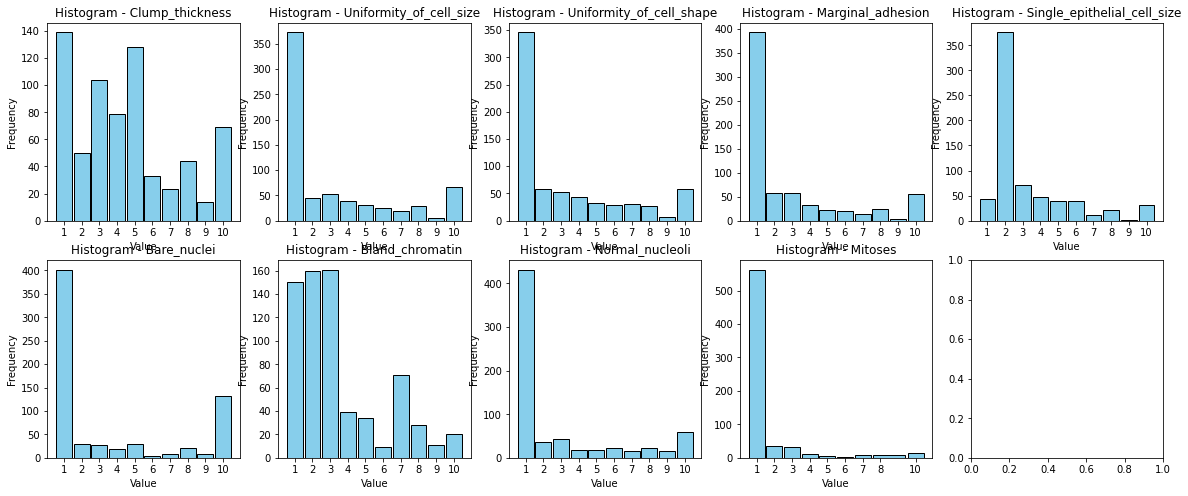

In [52]:
columns = [
    "Clump_thickness",
    "Uniformity_of_cell_size",
    "Uniformity_of_cell_shape",
    "Marginal_adhesion",
    "Single_epithelial_cell_size",
    "Bare_nuclei",
    "Bland_chromatin",
    "Normal_nucleoli",
    "Mitoses",
]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    
    # 1) Get unique values from that column
    unique_values = sorted(set(x[col]))

    # 2) Build the bins from unique_values
    if len(unique_values) == 1:
        bins = [unique_values[0] - 0.5, unique_values[0] + 0.5]
    else:
        bins = [val - 0.5 for val in unique_values] + [unique_values[-1] + 0.5]

    # 3) Plot only that column’s data
    ax.hist(x[col], bins=bins, edgecolor='black', rwidth=0.9, color='skyblue')

    ax.set_title(f"Histogram - {col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xticks(unique_values)


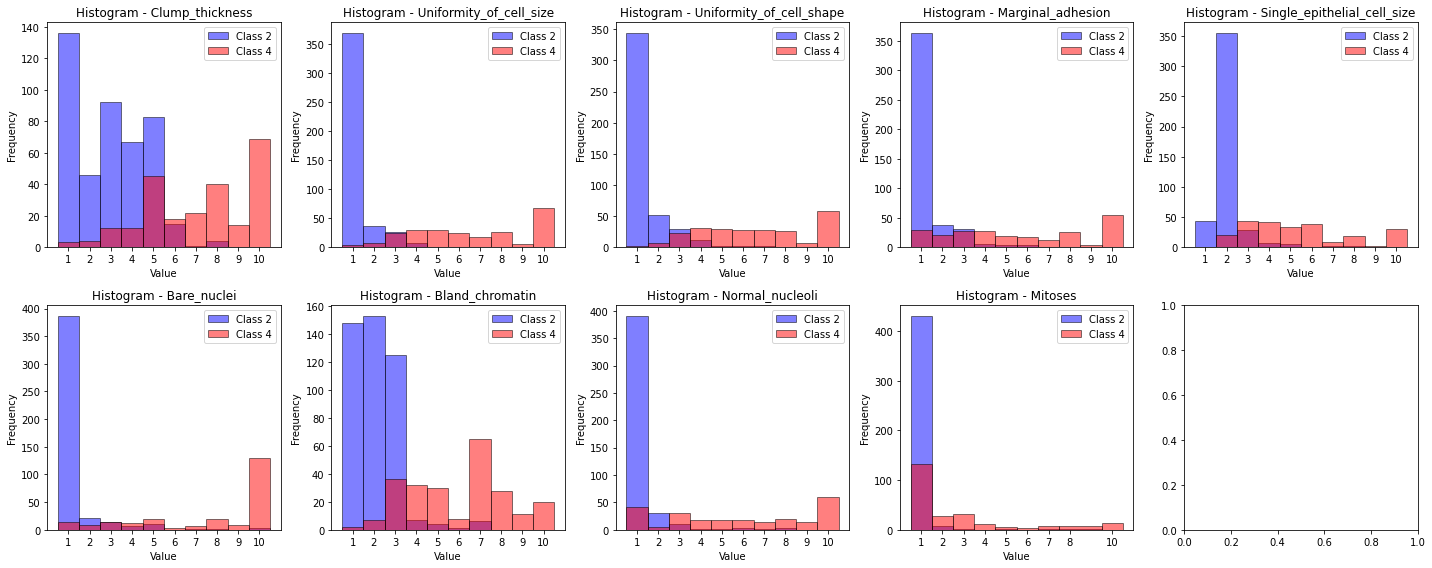

In [53]:
unique_classes = classes.unique() 
colors = ['blue', 'red']          

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    
    feature_data = x[col].dropna()
    unique_vals = sorted(feature_data.unique())
    
    if len(unique_vals) == 1:
        # Edge case: if there's effectively only 1 unique value
        bins = [unique_vals[0] - 0.5, unique_vals[0] + 0.5]
    else:
        bins = [v - 0.5 for v in unique_vals] + [unique_vals[-1] + 0.5]
    
    # Plot each class's distribution on the same subplot
    for class_label, color in zip(unique_classes, colors):
        subset = x[col][classes == class_label].dropna()
        ax.hist(
            subset,
            bins=bins,
            alpha=0.5,       # transparency
            color=color,
            label=f"Class {class_label}",
            edgecolor='black'
        )

    ax.set_title(f"Histogram - {col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xticks(unique_vals)
    ax.legend()

plt.tight_layout()
plt.show()


In [54]:
desc_by_class = X.groupby(classes).describe()
print(desc_by_class)

###
# desc_by_class.to_latex("table_descriptive_stats.tex", float_format="%.2f")
###

      Clump_thickness                                                 \
                count      mean       std  min  25%  50%   75%   max   
Class                                                                  
2               444.0  2.963964  1.672661  1.0  1.0  3.0   4.0   8.0   
4               239.0  7.188285  2.437907  1.0  5.0  8.0  10.0  10.0   

      Uniformity_of_cell_size            ... Normal_nucleoli       Mitoses  \
                        count      mean  ...             75%   max   count   
Class                                    ...                                 
2                       444.0  1.306306  ...             1.0   8.0   444.0   
4                       239.0  6.577406  ...             9.5  10.0   239.0   

                                                     
           mean       std  min  25%  50%  75%   max  
Class                                                
2      1.065315  0.509738  1.0  1.0  1.0  1.0   8.0  
4      2.602510  2.564495  1.0  

#### 2.4 Scaling

In [55]:
from preprocessing import StandardScaler

x = x.to_numpy()
x = x.astype(float)

sc = StandardScaler()
sc.fit(x)

X_scaled = sc.transform(x)

In [77]:
column_names = X.columns  

X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

X_scaled_df.describe()


,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
count,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02
mean,2.813757e-16,-2.899909e-16,-4.431139e-16,2.144047e-16,-5.439768e-16,-1.563415e-15,-2.223697e-16,-7.737425e-17,1.050404e-15
std,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00
min,-1.221191e+00,-7.022120e-01,-7.417736e-01,-6.393655e-01,-1.005763e+00,-6.988531e-01,-9.988531e-01,-6.129274e-01,-3.483997e-01
25%,-8.664174e-01,-7.022120e-01,-7.417736e-01,-6.393655e-01,-5.556085e-01,-6.988531e-01,-5.903401e-01,-6.129274e-01,-3.483997e-01
50%,-1.568693e-01,-7.022120e-01,-7.417736e-01,-6.393655e-01,-5.556085e-01,-6.988531e-01,-1.818272e-01,-6.129274e-01,-3.483997e-01
75%,5.526787e-01,6.037398e-01,5.976352e-01,4.086824e-01,3.447014e-01,6.743249e-01,6.351988e-01,3.705403e-01,-3.483997e-01
max,1.971775e+00,2.236180e+00,2.271896e+00,2.504778e+00,3.045631e+00,1.772867e+00,2.677764e+00,2.337476e+00,4.849690e+00


# 3. PCA

#### 3.1 Apply PCA on features

In [56]:
from pca import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
loadings = pca.loadings_

print("Explained variances: ", pca.explained_variance_ratio_)
print("Loadings: \n", loadings)

Explained variances:  [0.65549993 0.08621632]
Loadings: 
 [[ 0.734214    0.12411905]
 [ 0.92558151  0.04111456]
 [ 0.91777801  0.07265739]
 [ 0.80874072  0.04592244]
 [ 0.8172735  -0.14492642]
 [ 0.81443806  0.23030752]
 [ 0.84039725  0.20105515]
 [ 0.81571141 -0.02994169]
 [ 0.55955545 -0.79827052]]


#### 3.2 Visualization: PCA loadings

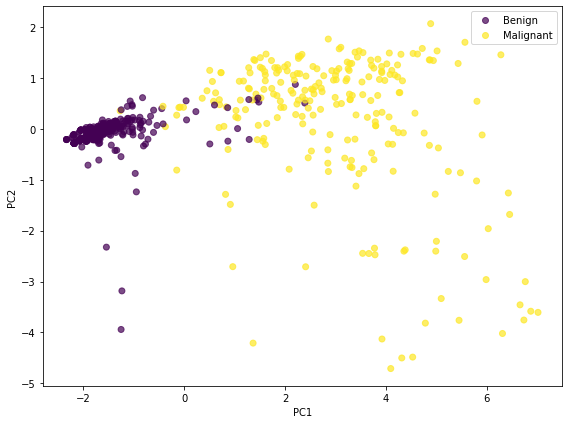

In [57]:
plt.figure(figsize=(8, 6))


scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=classes,                
    cmap='viridis',
    alpha=0.7
)

handles, _ = scatter.legend_elements()
labels = ["Benign", "Malignant"]

plt.legend(handles, labels, loc="best")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


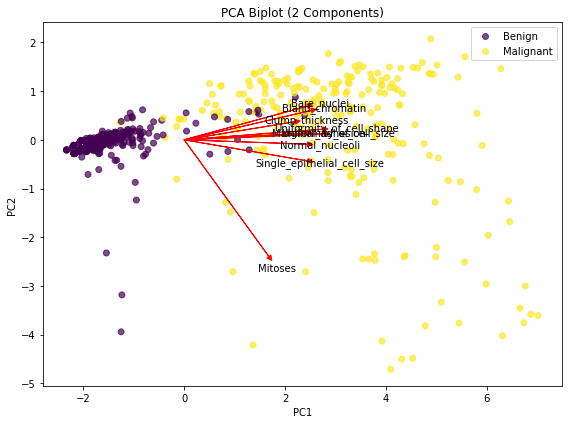

In [58]:
# X_pca shape: (n_samples, 2)
# pca.loadings_ shape: (n_features, 2)
# explained variance: pca.explained_variance_

# 1) Plot the data in PCA space
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=classes,          # color by class, if available
    cmap='viridis',
    alpha=0.7
)

handles, _ = scatter.legend_elements()
ax.legend(handles, ["Benign", "Malignant"], loc="best")
# Optionally create a legend or colorbar
# If 'classes' is numeric or ordinal, a colorbar might be better:
# plt.colorbar(scatter, label='Class')

# 2) Draw loadings arrows
loadings = pca.loadings_  # shape: (n_features, 2)
# Decide on a scale factor so the arrows are visually distinct
scalefactor = 3

# If you have the original column names:
feature_names = X.columns  # or a list of your feature names
for i, v in enumerate(loadings):
    # v is a length-2 vector: [loading on PC1, loading on PC2]
    ax.arrow(
        0, 0,               # start at origin
        scalefactor * v[0], # PC1 loading
        scalefactor * v[1], # PC2 loading
        color='red',
        head_width=0.1,
        head_length=0.1
    )
    ax.text(
        scalefactor * v[0] * 1.1,
        scalefactor * v[1] * 1.1,
        feature_names[i],   # label each arrow with the feature name
        color='black',
        ha='center',
        va='center'
    )


ax.set_xlabel(f"PC1")
ax.set_ylabel(f"PC2")
ax.set_title("PCA Biplot (2 Components)")

plt.tight_layout()
plt.show()


#### 3.3 Feature loadings as a table

In [59]:
# Analysis of loadings
loadings = pca.pcs_ * np.sqrt(pca.explained_variance_)
loadings

array([[ 0.734214  ,  0.12411905],
       [ 0.92558151,  0.04111456],
       [ 0.91777801,  0.07265739],
       [ 0.80874072,  0.04592244],
       [ 0.8172735 , -0.14492642],
       [ 0.81443806,  0.23030752],
       [ 0.84039725,  0.20105515],
       [ 0.81571141, -0.02994169],
       [ 0.55955545, -0.79827052]])

In [60]:
# Number of principal components
n_pcs = pca.pcs_.shape[1]

# Create principal component labels
pc_labels = [f"PC{i+1}" for i in range(n_pcs)]

# Create the DataFrame
loadings_df = pd.DataFrame(
    loadings.T,
    index=pc_labels,
    columns=feature_names
)

# Display the Loadings Table
print(loadings_df.round(3))


     Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
PC1            0.734                    0.926                     0.918   
PC2            0.124                    0.041                     0.073   

     Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei  \
PC1              0.809                        0.817        0.814   
PC2              0.046                       -0.145        0.230   

     Bland_chromatin  Normal_nucleoli  Mitoses  
PC1            0.840            0.816    0.560  
PC2            0.201           -0.030   -0.798  


# 4. Clustering

#### 4.1 Hierarchical Agglomerative Clustering

In [61]:
from hac import HAC
from metrics import adjusted_rand_index, silhouette_score, davies_bouldin_score

# It has been found that linkage: complete, n_clusters: 2, and metric:cosine gives the most optimal scores

params = {
    'n_clusters': [2, 3, 4],
    'linkage': ['single', 'complete', 'ward'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

def evaluate_clustering(X, labels, true_labels):
    """
    Returns a dictionary of metrics for given clustering results.
    """
    results = {}
    results['ARI'] = adjusted_rand_index(true_labels, labels)
    results['Silhouette'] = silhouette_score(X, labels)
    results['DaviesBouldin'] = davies_bouldin_score(X, labels)
    return results

results = []
for linkage in params['linkage']:
        for affinity in params['metric']:
            for n_clusters in params['n_clusters']:
                
                if linkage == 'ward' and metric != 'euclidean':
                    continue

                clusterer = HAC(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric=metric
                )

                clusterer.fit(X_scaled)
                labels = clusterer.labels_

                metrics = evaluate_clustering(X_scaled, labels, classes)

                # Decide which metric to maximize (e.g. ARI)
                score_for_selection = metrics_dict['Silhouette']

df__hac_results = pd.DataFrame(results)

# Print best results
print("Best Params:", best_params)
print("All Metrics for Best Params:", best_metrics)


Best Params: {'n_clusters': 2, 'linkage': 'complete', 'affinity': 'cosine'}
All Metrics for Best Params: {'ARI': 0.890981602222408, 'Silhouette': 0.5603535875557032, 'DaviesBouldin': 0.8287008462046664}


In [62]:
hac = HAC(linkage=best_params['linkage'], n_clusters=best_params['n_clusters'])
hac.fit(X_scaled)

,n_clusters,linkage,metric,ARI,Silhouette,DaviesBouldin
15,2,complete,cosine,0.890982,0.560354,0.828701
18,2,ward,euclidean,0.852567,0.546994,0.846258
19,3,ward,euclidean,0.798808,0.534597,1.186210
9,2,complete,euclidean,0.479502,0.530782,0.912682
16,3,complete,cosine,0.824259,0.515746,2.299610
12,2,complete,manhattan,0.389308,0.511025,0.966159
11,4,complete,euclidean,0.756706,0.504675,1.614319
14,4,complete,manhattan,0.756072,0.500001,1.633640
10,3,complete,euclidean,0.449780,0.495105,1.256412
13,3,complete,manhattan,0.369958,0.486619,1.206285


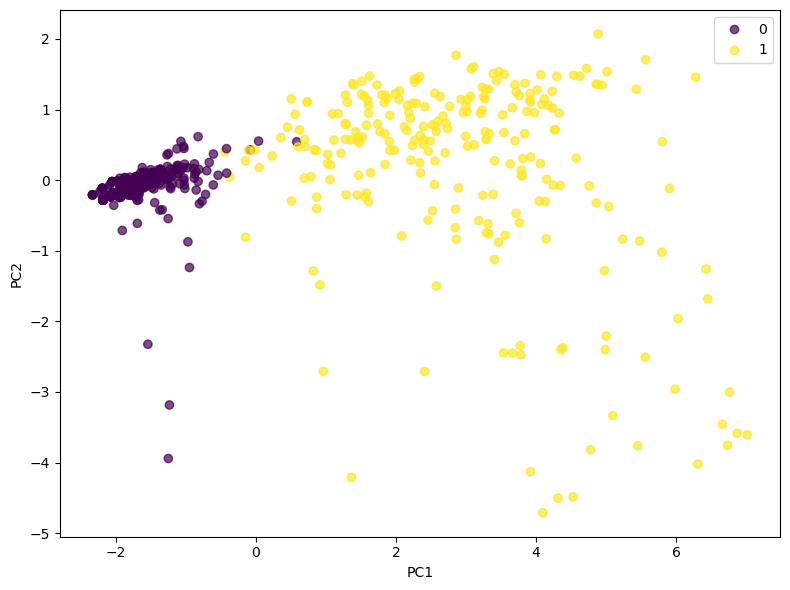

In [63]:
# Mean and SD for each feature in separate clusters
df_temp = X.copy()
df_temp['Cluster'] = hac_labels

results = []

for cluster, group in df_temp.groupby('Cluster'):
    means = group.iloc[:, :-1].mean()  # Compute mean for each feature
    stds = group.iloc[:, :-1].std()  # Compute standard deviation

    for feature in means.index:
        results.append({
            'Cluster': cluster,
            'Feature': feature,
            'Mean': means[feature],
            'SD': stds[feature]
        })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results

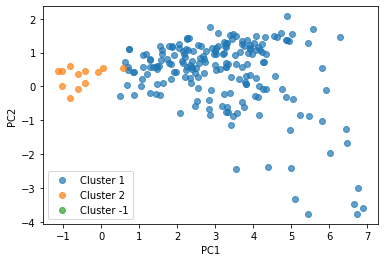

In [64]:
    
# Plot clusters
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {label}',
                alpha=0.7)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

#### 4.2 K-Means

In [65]:
from kmeans import KMeans

# Define parameter grid for K-Means
params = {
    'n_clusters': [2, 3, 4, 5, 6]
}

# Initialize variables to store the best results
best_score = -np.inf
best_params = {}
best_metrics = {}

# Iterate over the number of clusters
for n_clusters in params['n_clusters']:
    # Initialize and fit the K-Means model
    clusterer = KMeans(
        n_clusters=n_clusters,
        max_iter=300,         
        tol=1e-4,             
    )
    
    clusterer.fit(X_scaled)
    labels = clusterer.labels_
    
    # Evaluate clustering performance
    metrics_dict = evaluate_clustering(X_scaled, labels, classes)
    
    # Select the metric to maximize (e.g., Adjusted Rand Index)
    score_for_selection = metrics_dict.get('Silhouette', 0)  # Ensure 'ARI' exists
    
    # Update best parameters if current score is better
    if score_for_selection > best_score:
        best_score = score_for_selection
        best_params = {
            'n_clusters': n_clusters
        }
        best_metrics = metrics_dict

# Print best results
print("Best ARI Score: {:.4f}".format(best_score))
print("Best Params:", best_params)
print("All Metrics for Best Params:", best_metrics)


Best ARI Score: 0.5724
Best Params: {'n_clusters': 2}
All Metrics for Best Params: {'ARI': 0.8575029605818916, 'Silhouette': 0.5724088085754669, 'DaviesBouldin': 0.8194633130937863}


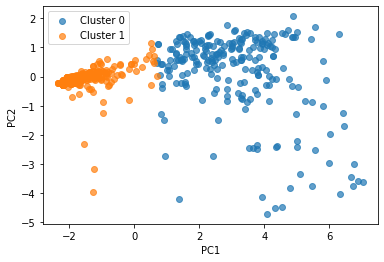

In [66]:

kmeans = KMeans(
        n_clusters=best_params['n_clusters'],
        max_iter=300,         
        tol=1e-4,             
    )

kmeans.fit(X_scaled)
labels = kmeans.labels_
unique_labels = set(labels)
    
# Plot clusters
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {label}',
                alpha=0.7)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

#### 4.3 DBSCAN

Best Params: {'eps': 1.45, 'min_samples': 7}
All Metrics for Best Params: {'ARI': 0.8245079539564741, 'Silhouette': 0.7059186343371092, 'DaviesBouldin': 0.5275751119726513}


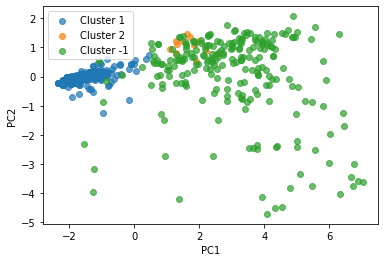

In [67]:
# Define the grid of hyperparameters for DBSCAN
params = {
    'eps': [1.2, 1.45, 1.60, 1.75, 2.0],
    'min_samples': [5, 7, 10, 12, 15, 17, 20]
}

best_score = -np.inf
best_params = None
best_metrics = None

def evaluate_clustering(X, labels, true_labels):
    """
    Evaluate clustering performance with several metrics.
    Returns a dictionary with ARI, Silhouette, and Davies-Bouldin scores.
    """
    results = {}
    results['ARI'] = adjusted_rand_index(true_labels, labels)
    try:
        results['Silhouette'] = silhouette_score(X, labels)
    except Exception as e:
        # Silhouette may fail if the clustering is degenerate (e.g., a single cluster or all noise)
        results['Silhouette'] = -1  
    try:
        results['DaviesBouldin'] = davies_bouldin_score(X, labels)
    except Exception as e:
        results['DaviesBouldin'] = np.inf  
    return results

# Grid search over eps and min_samples
for eps in params['eps']:
    for min_samples in params['min_samples']:
        # Initialize and fit DBSCAN with the current hyperparameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels = dbscan.labels_
        
        # Evaluate clustering performance
        metrics_dict = evaluate_clustering(X_scaled, labels, classes)
        score_for_selection = metrics_dict['Silhouette']  # You can change the selection criterion if desired
        
        # Save best parameters based on ARI
        if score_for_selection > best_score:
            best_score = score_for_selection
            best_params = {'eps': eps, 'min_samples': min_samples}
            best_metrics = metrics_dict

# Print best results
print("Best Params:", best_params)
print("All Metrics for Best Params:", best_metrics)

# Plot clusters for the best DBSCAN configuration
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan.fit(X_scaled)
labels = dbscan.labels_
unique_labels = set(labels)
    
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {label}',
                alpha=0.7)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [69]:
# Statistical test for cluster-class relationship
def test_cluster_class_relationship(labels, classes):
    print("\nStatistical Test of Class Proportions Between Clusters")
    print("-" * 50)
    
    # Create contingency table
    contingency = pd.crosstab(labels, classes)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    print(f"Contingency Table:")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.3f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")
    
    # Interpret results
    alpha = 0.05
    print("\nInterpretation:")
    if p_value < alpha:
        print(f"The relationship between clusters and classes is statistically significant (p < {alpha})")
    else:
        print(f"No statistically significant relationship between clusters and classes (p >= {alpha})")




In [70]:
# Perform statistical tests for each clustering method
print("\nHAC Clustering:")
test_cluster_class_relationship(hac.labels_, classes)

print("\nKMeans Clustering:")
test_cluster_class_relationship(kmeans.labels_, classes)

print("\nDBSCAN Clustering:")
test_cluster_class_relationship(dbscan.labels_, classes)



HAC Clustering:

Statistical Test of Class Proportions Between Clusters
--------------------------------------------------
Contingency Table:
Class    2    4
row_0          
0      442   99
1        2  140

Chi-square statistic: 315.245
p-value: 0.000000
Degrees of freedom: 1

Interpretation:
The relationship between clusters and classes is statistically significant (p < 0.05)

KMeans Clustering:

Statistical Test of Class Proportions Between Clusters
--------------------------------------------------
Contingency Table:
Class    2    4
row_0          
0       10  224
1      434   15

Chi-square statistic: 573.127
p-value: 0.000000
Degrees of freedom: 1

Interpretation:
The relationship between clusters and classes is statistically significant (p < 0.05)

DBSCAN Clustering:

Statistical Test of Class Proportions Between Clusters
--------------------------------------------------
Contingency Table:
Class    2    4
row_0          
-1      18  219
 1     425    9
 2       1   11

Chi-squa

In [82]:

def test_feature_distributions(X, labels, feature_names):
    """
    Compare feature distributions between clusters.

    - If exactly 2 clusters are present, uses Mann-Whitney U test.
    - If more than 2 clusters, uses Kruskal-Wallis test (non-parametric ANOVA).

    Parameters
    ----------
    X : pd.DataFrame
        Your dataset as a pandas DataFrame (without cluster labels).
    labels : array-like
        Cluster labels for each row in X.
    feature_names : list
        Names of the columns/features in X to test.

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame containing the test results (Feature, TestUsed, Statistic, P-value, Significant).
    """

    # Copy X so we can attach labels without modifying the original data
    X_df = X.copy()
    X_df['Cluster'] = labels
    
    # Find the unique clusters
    unique_clusters = X_df['Cluster'].unique()
    n_clusters = len(unique_clusters)

    print("\nFeature Distribution Tests Between Clusters")
    print("-" * 50)
    print(f"Number of clusters detected: {n_clusters}\n")

    results = []
    
    for feature in feature_names:
        # Prepare cluster subsets for this feature
        # We'll store them as a list of arrays, one array per cluster
        data_per_cluster = [
            X_df[X_df['Cluster'] == cluster_val][feature] 
            for cluster_val in unique_clusters
        ]
        
        # Decide which test to use based on number of clusters
        if n_clusters == 2:
            # Mann-Whitney U test (for two independent samples)
            stat, p_value = stats.mannwhitneyu(
                data_per_cluster[0],
                data_per_cluster[1],
                alternative='two-sided'
            )
            test_used = 'Mann-Whitney U'
        else:
            # Kruskal-Wallis H-test (non-parametric ANOVA for k independent samples)
            stat, p_value = stats.kruskal(*data_per_cluster)
            test_used = 'Kruskal-Wallis'
        
        results.append({
            'Feature': feature,
            'TestUsed': test_used,
            'Statistic': stat,
            'P-value': p_value
        })
    
    # Create and display results DataFrame
    results_df = pd.DataFrame(results)
    results_df['Significant'] = results_df['P-value'] < 0.05

    print("Test Results:")
    print(results_df)

    return results_df

print("\nHAC Clustering Feature Tests:")
test_feature_distributions(X_scaled_df, hac.labels_, feature_names)

print("\nKMeans Clustering Feature Tests:")
test_feature_distributions(X_scaled_df, kmeans.labels_, feature_names)

print("\nDBSCAN Clustering Feature Tests:")
test_feature_distributions(X_scaled_df, dbscan.labels_, feature_names)



HAC Clustering Feature Tests:

Feature Distribution Tests Between Clusters
--------------------------------------------------
Number of clusters detected: 2

Test Results:
                       Feature        TestUsed  Statistic       P-value  \
0              Clump_thickness  Mann-Whitney U    13768.0  1.081494e-32   
1      Uniformity_of_cell_size  Mann-Whitney U     1256.0  4.300098e-84   
2     Uniformity_of_cell_shape  Mann-Whitney U     2342.5  1.940235e-76   
3            Marginal_adhesion  Mann-Whitney U     7975.0  6.381974e-59   
4  Single_epithelial_cell_size  Mann-Whitney U     3173.5  3.394507e-76   
5                  Bare_nuclei  Mann-Whitney U    11346.0  4.727909e-48   
6              Bland_chromatin  Mann-Whitney U     5442.0  4.574215e-58   
7              Normal_nucleoli  Mann-Whitney U     6459.0  5.866910e-70   
8                      Mitoses  Mann-Whitney U    22686.0  8.995724e-30   

   Significant  
0         True  
1         True  
2         True  
3       

,Feature,TestUsed,Statistic,P-value,Significant
0,Clump_thickness,Kruskal-Wallis,305.395441,4.833064e-67,True
1,Uniformity_of_cell_size,Kruskal-Wallis,499.006738,4.385950e-109,True
2,Uniformity_of_cell_shape,Kruskal-Wallis,478.344518,1.345264e-104,True
3,Marginal_adhesion,Kruskal-Wallis,370.627743,3.305280e-81,True
4,Single_epithelial_cell_size,Kruskal-Wallis,463.752402,1.983561e-101,True
5,Bare_nuclei,Kruskal-Wallis,470.354631,7.307850e-103,True
6,Bland_chromatin,Kruskal-Wallis,367.635903,1.475292e-80,True
7,Normal_nucleoli,Kruskal-Wallis,406.944347,4.296926e-89,True
8,Mitoses,Kruskal-Wallis,208.060600,6.610202e-46,True


In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_cluster_distributions(X, labels, feature_names, plot_type='box'):
    """
    Visualize the distribution of each feature, grouped by cluster.

    Parameters
    ----------
    X : numpy.ndarray or pd.DataFrame
        The data, with shape (n_samples, n_features).
    labels : array-like
        Cluster labels for each sample.
    feature_names : list of str
        Names of the features (columns of X).
    plot_type : str, optional
        'box' for boxplot or 'violin' for violin plot.
    
    Returns
    -------
    None
        Displays the plot directly.
    """
    
    # If X is a NumPy array, convert it to a DataFrame for easy plotting
    if not isinstance(X, pd.DataFrame):
        X_df = pd.DataFrame(X, columns=feature_names)
    else:
        X_df = X.copy()
    
    # Add cluster labels as a new column
    X_df['Cluster'] = labels

    # Reshape the DataFrame from wide to long format for easy grouping
    #   - 'Feature' will be the column name
    #   - 'Value' will be the numeric data
    #   - 'Cluster' is our grouping variable
    melted = X_df.melt(id_vars='Cluster', 
                       var_name='Feature', 
                       value_name='Value')

    # Create a single figure for all features
    plt.figure(figsize=(10, 6))

    # Choose the plot type
    if plot_type == 'box':
        sns.boxplot(data=melted, x='Feature', y='Value', hue='Cluster')
    elif plot_type == 'violin':
        sns.violinplot(data=melted, x='Feature', y='Value', hue='Cluster', cut=0, scale='width')
    else:
        raise ValueError("plot_type must be either 'box' or 'violin'.")

    plt.title('Feature Distributions by Cluster')
    plt.xticks(rotation=45)         # Rotate feature labels if needed
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


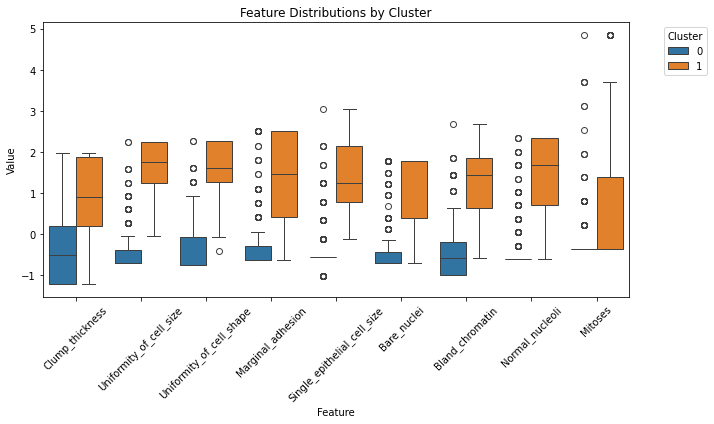

In [86]:
# Suppose X_scaled is your scaled dataset (NumPy array),
# labels is a list/array of cluster labels,
# and feature_names is a list of column names.

visualize_cluster_distributions(X_scaled, hac.labels_, feature_names, plot_type='box')


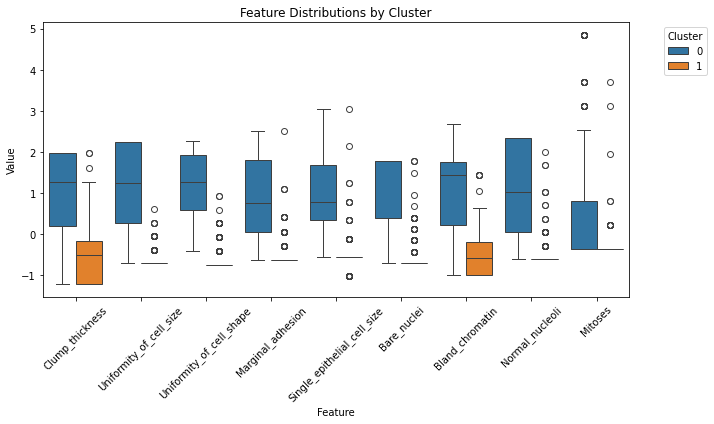

In [87]:

visualize_cluster_distributions(X_scaled, kmeans.labels_, feature_names, plot_type='box')



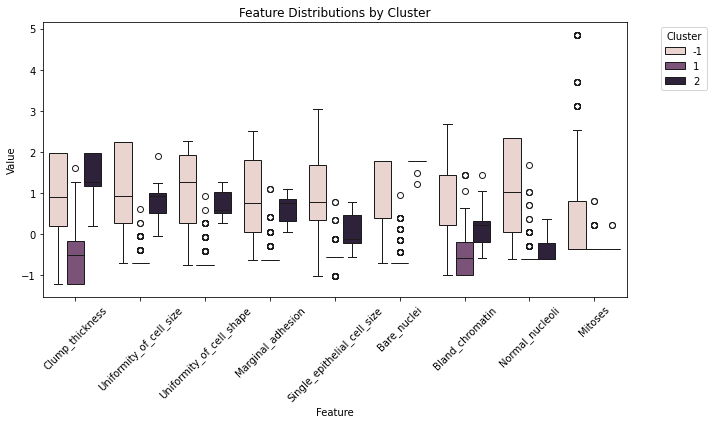

In [88]:
visualize_cluster_distributions(X_scaled, dbscan.labels_, feature_names, plot_type='box')


In [89]:
import pandas as pd

def summary_stats_by_group(X, labels, feature_names=None):
    """
    Displays summary statistics for each cluster side by side.
    
    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Dataset with shape (n_samples, n_features). 
        If it's a NumPy array, `feature_names` must be provided.
    labels : array-like
        Cluster or group labels for each sample.
    feature_names : list of str, optional
        Names of the features (columns of X), only required if X is a NumPy array.

    Returns
    -------
    summary_df : pd.DataFrame
        A DataFrame with summary statistics for each feature by cluster.
    """
    # If X is a NumPy array, convert it to a DataFrame
    if not isinstance(X, pd.DataFrame):
        if feature_names is None:
            raise ValueError("When passing a NumPy array, you must provide `feature_names`.")
        X_df = pd.DataFrame(X, columns=feature_names)
    else:
        X_df = X.copy()
    
    # Add the cluster labels as a column for grouping
    X_df['Cluster'] = labels
    
    # Group by 'Cluster' and compute descriptive statistics
    grouped_stats = X_df.groupby('Cluster').describe()
    
    # Transpose so that each cluster is shown in a separate column
    summary_df = grouped_stats.transpose()
    
    # Display
    print("\nSummary Statistics by Cluster (Side by Side):")
    display(summary_df)  # 'display()' in Jupyter or 'print(summary_df)' otherwise
    
    return summary_df


In [92]:
# Suppose `X_scaled` is your scaled dataset (DataFrame or NumPy array),
# `labels` are the cluster labels,
# and `feature_names` is the list of column names if you have a NumPy array.

summary_df = summary_stats_by_group(X_scaled, hac.labels_, feature_names)





Summary Statistics by Cluster (Side by Side):


Cluster                         0           1
Clump_thickness count  541.000000  142.000000
                mean    -0.238185    0.907453
                std      0.893556    0.859721
                min     -1.221191   -1.221191
                25%     -1.221191    0.197905
...                           ...         ...
Mitoses         min     -0.348400   -0.348400
                25%     -0.348400   -0.348400
                50%     -0.348400   -0.348400
                75%     -0.348400    1.384297
                max      4.849690    4.849690

[72 rows x 2 columns]

In [93]:
summary_df = summary_stats_by_group(X_scaled, kmeans.labels_, feature_names)




Summary Statistics by Cluster (Side by Side):


Cluster                         0           1
Clump_thickness count  234.000000  449.000000
                mean     0.965066   -0.502952
                std      0.863975    0.629557
                min     -1.221191   -1.221191
                25%      0.197905   -1.221191
...                           ...         ...
Mitoses         min     -0.348400   -0.348400
                25%     -0.348400   -0.348400
                50%     -0.348400   -0.348400
                75%      0.806731   -0.348400
                max      4.849690    3.694559

[72 rows x 2 columns]

In [94]:
summary_df = summary_stats_by_group(X_scaled, dbscan.labels_, feature_names)




Summary Statistics by Cluster (Side by Side):


Cluster                        -1           1          2
Clump_thickness count  237.000000  434.000000  12.000000
                mean     0.901465   -0.528810   1.321356
                std      0.911528    0.585164   0.582626
                min     -1.221191   -1.221191   0.197905
                25%      0.197905   -1.221191   1.173533
...                           ...         ...        ...
Mitoses         min     -0.348400   -0.348400  -0.348400
                25%     -0.348400   -0.348400  -0.348400
                50%     -0.348400   -0.348400  -0.348400
                75%      0.806731   -0.348400  -0.348400
                max      4.849690    0.806731   0.229166

[72 rows x 3 columns]